In [1]:
from __future__ import absolute_import, division, print_function

import pandas as pd
import numpy as np
import sklearn as sk
import os
import tensorflow as tf
from sklearn.feature_extraction import DictVectorizer
from sklearn.externals import joblib
from sklearn.model_selection import ParameterGrid
import seaborn as sns

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

In [2]:
# %load_ext autoreload
# %autoreload 2

In [3]:
data_path = "data/"

final_df_train = pd.read_csv(data_path + 'train_state_action_reward_df.csv')
final_df_val = pd.read_csv(data_path+ 'val_state_action_reward_df.csv')
final_df_test = pd.read_csv(data_path+ 'test_state_action_reward_df.csv')

In [4]:
patient_4 = final_df_train[final_df_train['subject_id'] == 4]

In [5]:
patient_4.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'interval_start_time',
       'interval_end_time', 'ALBUMIN', 'ANION GAP', 'BANDS', 'BICARBONATE',
       'BILIRUBIN', 'BUN', 'CHLORIDE', 'CREATININE', 'DiasBP', 'Glucose',
       'GLUCOSE', 'HeartRate', 'HEMATOCRIT', 'HEMOGLOBIN', 'INR', 'LACTATE',
       'MeanBP', 'PaCO2', 'PLATELET', 'POTASSIUM', 'PT', 'PTT', 'RespRate',
       'SODIUM', 'SpO2', 'SysBP', 'TempC', 'WBC', 'age', 'is_male',
       'race_white', 'race_black', 'race_hispanic', 'race_other', 'height',
       'weight', 'vent', 'sofa', 'lods', 'sirs', 'qsofa', 'qsofa_sysbp_score',
       'qsofa_gcs_score', 'qsofa_resprate_score', 'elixhauser_hospital',
       'blood_culture_positive', 'discrete_action', 'hospital_expire_flag',
       'reward', 'row_id', 'row_id_next'],
      dtype='object')

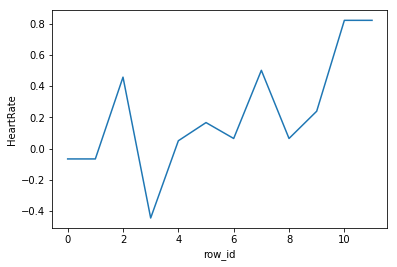

In [69]:
# look at one patient
sns.lineplot(x="row_id", y="HeartRate",
             data=patient_4)

In [73]:
# look at action counts
final_df_train.groupby("discrete_action").count()['subject_id']

discrete_action
0     37763
1     26903
2     26792
3     26607
4     22865
5         5
6       708
7       552
8       568
9      1313
11      519
12      496
13      602
14     1579
16      494
17      513
18      673
19     1528
21      308
22      549
23      749
24     1496
Name: subject_id, dtype: int64

In [74]:
final_df_train.groupby("hospital_expire_flag").count()

,subject_id,hadm_id,icustay_id,interval_start_time,interval_end_time,ALBUMIN,ANION GAP,BANDS,BICARBONATE,BILIRUBIN,...,qsofa,qsofa_sysbp_score,qsofa_gcs_score,qsofa_resprate_score,elixhauser_hospital,blood_culture_positive,discrete_action,reward,row_id,row_id_next
hospital_expire_flag,,,,,,,,,,,,,,,,,,,,,
0,131773,131773,131773,131773,131773,131773,131773,131773,131773,131773,...,131773,131773,131773,131773,131773,131773,131773,131773,131773,131773
1,21809,21809,21809,21809,21809,21809,21809,21809,21809,21809,...,21809,21809,21809,21809,21809,21809,21809,21809,21809,21809


In [75]:
# create data for RNN
final_df_train.head()

,subject_id,hadm_id,icustay_id,interval_start_time,interval_end_time,ALBUMIN,ANION GAP,BANDS,BICARBONATE,BILIRUBIN,...,qsofa_sysbp_score,qsofa_gcs_score,qsofa_resprate_score,elixhauser_hospital,blood_culture_positive,discrete_action,hospital_expire_flag,reward,row_id,row_id_next
0,4,185777,294638,2191-03-15T12:00:00Z,2191-03-15T16:00:00Z,-0.058925,0.767654,-0.393482,0.040999,0.048183,...,0.540022,-0.57893,0.390655,1.007645,1.461582,0,0,0,0.0,1.0
1,4,185777,294638,2191-03-15T20:00:00Z,2191-03-16T00:00:00Z,-0.058925,0.767654,-0.393482,0.040999,0.048183,...,0.540022,-0.57893,0.390655,1.007645,1.461582,0,0,0,1.0,2.0
2,4,185777,294638,2191-03-16T00:00:00Z,2191-03-16T04:00:00Z,-0.058925,0.767654,-0.393482,0.040999,0.048183,...,0.540022,-0.57893,0.390655,1.007645,1.461582,2,0,0,2.0,3.0
3,4,185777,294638,2191-03-16T04:00:00Z,2191-03-16T08:00:00Z,-0.487176,0.271412,-0.393482,-0.600421,-0.020244,...,0.540022,-0.57893,0.390655,1.007645,1.461582,4,0,0,3.0,4.0
4,4,185777,294638,2191-03-16T08:00:00Z,2191-03-16T12:00:00Z,-0.487176,0.271412,-0.393482,-0.600421,-0.020244,...,0.540022,-0.57893,0.390655,1.007645,1.461582,1,0,0,4.0,5.0


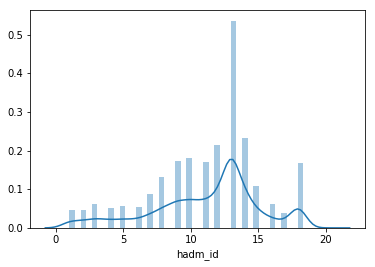

In [81]:
# episode length distribution
sns.distplot(final_df_train.groupby("subject_id").count()["hadm_id"])

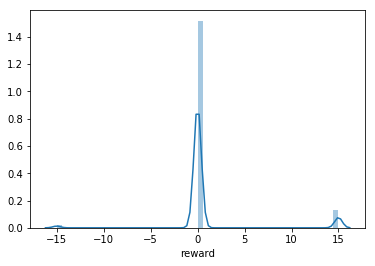

In [84]:
# reward distribution
sns.distplot(final_df_train["reward"])

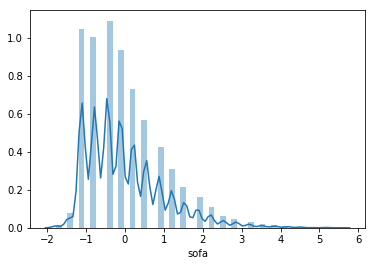

In [83]:
# sofa distribution
sns.distplot(final_df_train["sofa"])